# SiamAES: Siamese Networks for Automated Essay Scoring
Author: Sam Kadaba, Abel John




In [3]:
from collections import defaultdict

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import pickle
import itertools

from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig
import torch.nn as nn
from datasets import load_dataset, DatasetDict, Dataset
from torch.utils.data import DataLoader
from io import BytesIO
from matplotlib.figure import Figure

from transformers import AdamW, get_linear_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup
from transformers.modeling_outputs import TokenClassifierOutput
from tqdm.notebook import tqdm
import random
import re
from random import randint

import nltk
nltk.download('all')
from nltk.corpus import wordnet as wn
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/ubuntu/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/ubuntu/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/ubuntu/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/ubuntu/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/ubuntu/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_data]    |

## Utility Functions ##

In [4]:


#--------------------------------------------------------------------------------------------
def remove_punctuation(text):
     punctuations = '''!()-[]{};@:'",./?@#$%^+&*_~'''
     no_punct = ""
     for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
     return no_punct
#--------------------------------------------------------------------------------------------
def preprocess_text(text):
    text = re.sub(r'd+' , '', text)
    text = remove_punctuation(text)
    text = text.lower()
    text = text.strip()
    text = re.sub(r'bw{1,2}b', '', text)
    return text

def normalize_scores(dataset, num_classes, prompt):
  if(num_classes != None):
    s_qcut, percentiles = pd.qcut(dataset[prompt][:]['score'], q=num_classes, duplicates='drop', retbins=True)
    num_classes = len(percentiles)

    def normalize(example):
      flag = False
      for index in range(len(percentiles)-1):
        if(example["score"] >= percentiles[index] and example["score"] < percentiles[index+1]):
          example["score"] = index
          flag=True
      if(not flag):
        example["score"] = num_classes - 1
      example['essay'] = preprocess_text(example['essay'])
      return example

    dataset = dataset.map(normalize)
  else:
    num_classes = max(dataset[prompt][:]["score"])
  return dataset, num_classes

def select_samples(dataset, prompt, num_classes, neach):
  map_indexes = defaultdict(list)
  for i in range(len(dataset[prompt])):
    score = dataset[prompt][i]['score']
    map_indexes[score].append(i)
  return map_indexes

def modify(text, threshold=0.90):
  words = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(words)
  output = ""
  ps = PorterStemmer()
  map={'NNS':'n', 'NNPS':'n', 'NNP':'n', 'NN':'n', 'JJ':'a', 'JJR':'a', 
      'JJS':'a', 'RB':'r', 'RBR':'r', 'RBS':'r', 'WP':'r',
      'VB':'v', 'VBD':'v', 'VBG':'v', 'VBN':'v', 'VBP':'v', 'VBZ':'v'} 
  sample_rate = 1
  for i in range(0,len(words)):
      replacements = []
      epsilon = abs(np.random.randn())
      sample_rate*=threshold
      for syn in wn.synsets(words[i]):
          if tagged[i][1] == 'NNP' or tagged[i][1] == 'NNS' or tagged[i][1] == "NN" or tagged[i][1] == 'DT':
              break          
          word_type = tagged[i][1][0].lower(); 
          if syn.name().find("."+word_type+"."):
              if(tagged[i][1] in map.keys()):
                r = WordNetLemmatizer().lemmatize(syn.name()[0:syn.name().find(".")], map[tagged[i][1]])
              else:
                r = words[i]
              replacements.append(r)
      if len(replacements) > 0:
          replacement = replacements[randint(0,len(replacements)-1)] if epsilon < sample_rate else words[i]
          output = output + " " + replacement
      else:
          output = output + " " + words[i]
  return output

def augment(dataset, prompt, indexes, n_augment):
  last = len(dataset[prompt])
  for i in range(len(indexes)):
    for j in range(n_augment):
      new_item = {'essay':modify(dataset[prompt][indexes[i]]['essay']), 'score':dataset[prompt][indexes[i]]['score']}
      dataset[prompt] = dataset[prompt].add_item(new_item)
      indexes.append(last)
      last += 1
  return dataset, indexes

def train_test_split(l1, l2):
  ind = [0] + list(itertools.accumulate(l2))
  return  [l1[ind[i]:ind[i+1]] for i in range(len(ind)-1)]

def load_and_filter(prompt, num_classes=None, neach=2, n_augment=10, split=[10, 10]):
  dataset = load_dataset("Ericwang/ASAP")
  num_classes = num_classes if num_classes != None else None
  dataset, num_classes = normalize_scores(dataset, num_classes, prompt)
  map_indexes = select_samples(dataset, prompt, num_classes, neach)

  desired = [neach, split[0], split[1]]
  train = []
  val = []
  test = []
  for score in range(num_classes):
    splits = train_test_split(map_indexes[score], desired)
    train += splits[0]
    val += splits[1]
    test += splits[2]

  dataset, indexes = augment(dataset, prompt, train, n_augment)
  random.shuffle(train); random.shuffle(val); random.shuffle(test)
  dataset = DatasetDict(
      train=dataset[prompt].select(indexes),
      val=dataset[prompt].select(val),
      test=dataset[prompt].select(test),
  )
  return dataset, num_classes

In [5]:
def tokenize(dataset, batch_size):
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
  tokenized_dataset = dataset.map(
      lambda example: tokenizer(example['essay'], padding='max_length', truncation=True),
      batched=True,
      batch_size=batch_size
  )
  essays = tokenized_dataset['test']['essay']
  tokenized_dataset = tokenized_dataset.remove_columns(["essay"])
  tokenized_dataset = tokenized_dataset.rename_column("score", "labels")
  tokenized_dataset.set_format("torch")

  train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, num_workers=4, pin_memory=True);
  eval_dataloader = DataLoader(tokenized_dataset['val'], batch_size=batch_size, num_workers=4, pin_memory=True);
  test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=1)

  return train_dataloader, eval_dataloader, test_dataloader, essays

In [6]:
def gen_data(prompt, num_classes, n_each, n_augment, flag, split):
  counts = defaultdict(int)
  dataset, num_classes = load_and_filter(prompt, num_classes, n_each, n_augment, split)
  batch_size = 1
  train_dataloader, eval_dataloader, test_dataloader, essays = tokenize(dataset, batch_size)

  batches_train = []
  for batch_i, batch in enumerate(train_dataloader):
    batches_train.append(batch)
  batches_eval = []
  for batch_i, batch in enumerate(eval_dataloader):
    batches_eval.append(batch)
  batches_test = []
  for batch_i, batch in enumerate(test_dataloader):
    batches_test.append(batch)

  if(flag == 1):
    train_dataloader = list(itertools.combinations(batches_train, 2)); 
    #eval_dataloader = list(itertools.combinations(batches_eval, 2)); 

  elif(flag == 2):

    train_dataloader = list(itertools.permutations(batches_train, 3))
    train_dataloader = [(x,y,z) for (x,y,z) in train_dataloader if x['labels'] == y['labels'] and x['labels'] != z['labels']]

  for batch in batches_test:
    counts[batch['labels'].item()]+=1

  return num_classes, counts, train_dataloader, eval_dataloader, test_dataloader, essays, batches_train, batches_test


## Baseline ##

In [7]:
class BaselineModel(torch.nn.Module):
  def __init__(self,num_classes): 
    super(BaselineModel,self).__init__() 
    self.num_labels = num_classes


    self.dropout = nn.Dropout(0.2) 

    # Configure DistilBERT's initialization
    config = DistilBertConfig(output_hidden_states=True, dropout=0.2)

    self.model = DistilBertModel.from_pretrained("distilbert-base-uncased", config=config)
    for name, param in list(self.model.named_parameters())[:-2]: 
        param.requires_grad = False
    self.classifier = nn.Linear(768, num_classes) # load and initialize weights

  def forward(self, input_ids=None, attention_mask=None, labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state
    embed = sequence_output[:,0,:].view(-1,768)
    logits = self.classifier(embed) # calculate losses
    
    target = torch.nn.functional.one_hot(labels, num_classes=self.num_labels).double()
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), target)

    return (TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions), embed, target)

In [8]:
def train_baseline(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath, lr):
  num_training_steps = num_epochs * len(train_dataloader)
  optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
  lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

  best_val_loss = float("inf")
  progress_bar = tqdm(range(num_training_steps))

  train_loss_history = []
  val_loss_history = []

  for epoch in range(num_epochs):
      # training
      model.train()
      train_loss = 0
      for batch_i, batch in enumerate(train_dataloader):
          batch = {k: v.to(device) for k, v in batch.items()}
          # batch = ([text1, text2], [0, 1])
          output = model(**batch)
          output = output[0]
          
          optimizer.zero_grad()
          train_loss += output.loss
          output.loss.backward()
          optimizer.step()
          lr_scheduler.step()
          progress_bar.update(1)

      avg_train_loss = train_loss/len(train_dataloader)
      # validation
      model.eval()
      val_loss = 0
      for batch_i, batch in enumerate(eval_dataloader):
          batch = {k: v.to(device) for k, v in batch.items()}
          with torch.no_grad():
              output = model(**batch)
              output = output[0]
          val_loss += output.loss
      
      avg_val_loss = val_loss / len(eval_dataloader)
      train_loss_history.append(avg_train_loss.cpu().item())
      val_loss_history.append(avg_val_loss.cpu().item())
      print(f"Epoch {epoch+1}" + " | " + f"Training loss: {avg_train_loss}" + " | " + f"Validation loss: {avg_val_loss}")
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
  return model, train_loss_history, val_loss_history


## Siamese Network ##

In [9]:
class SiameseNetworkLSTM(nn.Module):

    def __init__(self, num_labels):
        super(SiameseNetworkLSTM, self).__init__()
        self.num_labels = num_labels
        self.dropout = nn.Dropout(0.3) 
        self.LSTM = nn.LSTM(768, 768, bias=True, bidirectional=True)
        self.LSTM.train()
        # Configure DistilBERT's initialization
        config = DistilBertConfig(output_hidden_states=True, dropout=0.1)

        self.model = model = DistilBertModel.from_pretrained("distilbert-base-uncased", config=config)
        for name, param in list(self.model.named_parameters())[:-2]: 
            param.requires_grad = False
        
        self.classifier = nn.Linear(768, num_labels) # load and initialize weights
        torch.nn.init.xavier_uniform(self.classifier.weight)

    def forward_one(self, input_ids=None, attention_mask=None, labels=None):
        token_embeds = self.model.get_input_embeddings().weight[input_ids].detach().clone()
        token_embeds.requires_grad = True
        outputs = self.model(inputs_embeds=token_embeds, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state
        # print(sequence_output.size())
        encoder_input = sequence_output[0,:,:].squeeze(0).view(-1,768)
        # print("LSTM_input:", encoder_input.size())
        LSTM_values = self.LSTM(encoder_input)
        # embedding corresponding to final hidden state
        embed = LSTM_values[1][0]
        # average beginning and end vectors
        embed = (torch.add(embed[0,:], embed[1,:]) / 2).unsqueeze(0)
        # print("embedding size:", embed.size())
        return LSTM_values[0], embed, token_embeds


    def forward(self, x1, x2, x3=None):

        outputs_x1, out_x1, token_embeds_x1 = self.forward_one(**x1)
        logits_x1 = self.classifier(out_x1)
        target_x1 = torch.nn.functional.one_hot(x1['labels'], num_classes=self.num_labels).double()
        args_x1 = (logits_x1, target_x1, outputs_x1, token_embeds_x1)

        if(x2 is not None):
          outputs_x2, out_x2, token_embeds_x2 = self.forward_one(**x2)
          logits_x2 = self.classifier(out_x2)
          target_x2 = torch.nn.functional.one_hot(x2['labels'], num_classes=self.num_labels).double()
          args_x2 = (logits_x2, target_x2, outputs_x2, token_embeds_x2)
          return out_x1, out_x2, args_x1, args_x2
        else:
          # grad = torch.autograd.grad(logits_x1[0][0], token_embeds_x1);
          args_x1 = (logits_x1, target_x1, outputs_x1)
          return out_x1, args_x1

In [10]:
class SiameseNetwork(nn.Module):

    def __init__(self, num_labels):
        super(SiameseNetwork, self).__init__()
        self.num_labels = num_labels
        self.dropout = nn.Dropout(0.1) 

        # Configure DistilBERT's initialization
        config = DistilBertConfig(output_hidden_states=True, dropout=0.1)

        self.model = model = DistilBertModel.from_pretrained("distilbert-base-uncased", config=config)
        for name, param in list(self.model.named_parameters())[:-2]: 
            param.requires_grad = False
        
        self.classifier = nn.Linear(768, num_labels) # load and initialize weights
        torch.nn.init.xavier_uniform(self.classifier.weight)

    def forward_one(self, input_ids=None, attention_mask=None, labels=None):
        token_embeds = self.model.get_input_embeddings().weight[input_ids].detach().clone()
        token_embeds.requires_grad = True
        outputs = self.model(inputs_embeds=token_embeds, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

        embed = sequence_output[:, 0, :].view(-1, 768)#torch.sum(sequence_output,1).view(-1,768)
        return outputs, embed, token_embeds


    def forward(self, x1, x2, x3):

        outputs_x1, out_x1, token_embeds_x1 = self.forward_one(**x1)
        logits_x1 = self.classifier(out_x1)
        target_x1 = torch.nn.functional.one_hot(x1['labels'], num_classes=self.num_labels).double()
        args_x1 = (logits_x1, target_x1, outputs_x1, token_embeds_x1)

        if(x2 is not None):
          outputs_x2, out_x2, token_embeds_x2 = self.forward_one(**x2)
          logits_x2 = self.classifier(out_x2)
          target_x2 = torch.nn.functional.one_hot(x2['labels'], num_classes=self.num_labels).double()
          args_x2 = (logits_x2, target_x2, outputs_x2, token_embeds_x2)
          if(x3 is None):
            return out_x1, out_x2, args_x1, args_x2
          else:
            outputs_x3, out_x3, token_embeds_x3 = self.forward_one(**x2)
            logits_x3 = self.classifier(out_x3)
            target_x3 = torch.nn.functional.one_hot(x3['labels'], num_classes=self.num_labels).double()
            args_x3 = (logits_x3, target_x3, outputs_x3, token_embeds_x3)
            return out_x1, out_x2, out_x3, args_x1, args_x2, args_x3
        else:
          y = logits_x1[0]
          grad = torch.autograd.grad(outputs=y, inputs=token_embeds_x1, grad_outputs=torch.ones_like(y))
          args_x1 = (logits_x1, target_x1, outputs_x1, grad)
          return out_x1, args_x1
                                
                              
class CrossEntropyLoss(torch.nn.Module):
  def __init__(self, num_labels):
    super(CrossEntropyLoss, self).__init__()  # pre 3.3 syntax
    self.num_labels = num_labels
    self.softmax = nn.Softmax(dim=1)
    
  def forward(self, x):
    loss_fct = nn.CrossEntropyLoss()
    logits = x[0]; target = x[1]; outputs = x[2]
    #print(self.softmax(logits), target)
    soft = self.softmax(logits)
    loss = loss_fct(logits, target)
    entropy =  soft@torch.log(soft).T
    gamma = 0.3
    return gamma*entropy + loss

class ContrastiveLoss(torch.nn.Module):
  def __init__(self, m=1):
    super(ContrastiveLoss, self).__init__()  # pre 3.3 syntax
    self.m = m  # margin or radius

  def forward(self, y1, y2, flag):
    # flag = 1 means y1 and y2 are supposed to be same
    # flag = 0 means y1 and y2 are supposed to be different
    pdist = nn.PairwiseDistance(p=2)
    self.m = (torch.norm(y1, 1) + torch.norm(y2, 1)) / 2
    #cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    euc_dist = pdist(y1, y2)
    if(flag != None):
      loss = torch.mean(flag * torch.pow(euc_dist, 2) + (1-flag) * torch.pow(torch.clamp(self.m - euc_dist, min=0.0), 2))
    else:
      loss = euc_dist
    return loss 
    
class TripletLoss(torch.nn.Module):
    def __init__(self, m=1.0):
      super(TripletLoss, self).__init__()  # pre 3.3 syntax
      self.m = m  # margin or radius
    def forward(self, anchor, positive, negative):
      triplet_loss = nn.TripletMarginLoss(margin=self.m, p=2)
      loss = triplet_loss(anchor, positive, negative)
      return loss 
        

In [11]:
import os 
import shutil 

def train_siamese_contrastive(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath, lr):
  loss_func = ContrastiveLoss()
  loss_func_classification = CrossEntropyLoss(num_classes)

  num_training_steps = num_epochs * len(train_dataloader)
  optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
  lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

  best_val_loss = float("inf")
  progress_bar = tqdm(range(num_training_steps))

  train_loss_history = []
  val_loss_history = []
  alpha, beta, gamma = 1, 1, 1
  for epoch in range(num_epochs):
      # training
      model.train()
      train_loss = 0
      for (sample1, sample2) in train_dataloader:
          sample1 = {k: v.to(device) for k, v in sample1.items()}
          sample2 = {k: v.to(device) for k, v in sample2.items()}
          # batch = ([text1, text2], [0, 1])
          out_x1, out_x2, update_x1, update_x2 = model(sample1, sample2, None)
          
          optimizer.zero_grad()
          flag = sample1['labels'] == sample2['labels']; flag = flag.cpu().item()

          loss_val = gamma*loss_func(out_x1, out_x2, flag)
          loss_val.backward(retain_graph=True)         # compute grads
          optimizer.step()            # update weights

          x1_classification_val = alpha*loss_func_classification(update_x1)
          x1_classification_val.backward(retain_graph=True)         # compute grads
          optimizer.step()            # update weights

          x2_classification_val = beta*loss_func_classification(update_x2)
          x2_classification_val.backward()         # compute grads
          optimizer.step()  

          train_loss += alpha*loss_val.item() + beta*x1_classification_val.item() + gamma*x2_classification_val.item()
    
          lr_scheduler.step()
          progress_bar.update(1)

      avg_train_loss = train_loss/len(train_dataloader)

      # validation
      model.eval()
      val_loss = 0
      for sample1 in eval_dataloader:
          sample1 = {k: v.to(device) for k, v in sample1.items()}
          #sample2 = {k: v.to(device) for k, v in sample2.items()}
          #flag = sample1['labels'] == sample2['labels']; flag = flag.cpu().item()
          #with torch.no_grad():
          out_x1, update_x1 = model(sample1, None, None)
          x1_classification_val = loss_func_classification(update_x1)
                #x2_classification_val = loss_func_classification(update_x2)
                #loss_val = loss_func(out_x1, out_x2, flag) 
          val_loss +=  x1_classification_val.detach().cpu().item() #+ loss_val.item() + x2_classification_val.item()

      avg_val_loss = val_loss / len(eval_dataloader)
      train_loss_history.append(avg_train_loss)
      val_loss_history.append(avg_val_loss)
      print(f"Epoch {epoch+1}" + " | " + f"Training loss: {avg_train_loss}" + " | " + f"Validation loss: {avg_val_loss}")
      if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
  return model, train_loss_history, val_loss_history
        

In [12]:
def train_siamese_triplet(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath, lr):
  loss_func = ContrastiveLoss()
  loss_func_classification = CrossEntropyLoss(num_classes)

  num_training_steps = num_epochs * len(train_dataloader)
  optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
  lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

  best_val_loss = float("inf")
  progress_bar = tqdm(range(num_training_steps))

  train_loss_history = []
  val_loss_history = []
  alpha, beta, gamma = 1, 1, 1
  for epoch in range(num_epochs):
      # training
      model.train()
      train_loss = 0
      for (sample1, sample2, sample3) in train_dataloader:
          sample1 = {k: v.to(device) for k, v in sample1.items()}
          sample2 = {k: v.to(device) for k, v in sample2.items()}
          sample3 = {k: v.to(device) for k, v in sample2.items()}
          # batch = ([text1, text2], [0, 1])
          out_x1, out_x2, out_x3, update_x1, update_x2, update_x3 = model(sample1, sample2, sample3)
          
          optimizer.zero_grad()
          flag = sample1['labels'] == sample2['labels']; flag = flag.cpu().item()
          
          loss_val = gamma*loss_func(out_x1, out_x2, out_x3)
          loss_val.backward(retain_graph=True)         # compute grads
          optimizer.step()            # update weights

          x1_classification_val = alpha*loss_func_classification(update_x1)
          x1_classification_val.backward(retain_graph=True)         # compute grads
          optimizer.step()            # update weights

          train_loss += loss_val.item() + x1_classification_val.item() 
    
          lr_scheduler.step()
          progress_bar.update(1)

      avg_train_loss = train_loss/len(train_dataloader)

      # validation
      model.eval()
      val_loss = 0
      for sample1 in eval_dataloader:
          sample1 = {k: v.to(device) for k, v in sample1.items()}
          flag = sample1['labels'] == sample2['labels']; flag = flag.cpu().item()
  
          out_x1, update_x1 = model(sample1, None, None)
          x1_classification_val = loss_func_classification(update_x1)
          val_loss +=  x1_classification_val.detach().cpu().item() 

      avg_val_loss = val_loss / len(eval_dataloader)
      train_loss_history.append(avg_train_loss)
      val_loss_history.append(avg_val_loss)
      print(f"Epoch {epoch+1}" + " | " + f"Training loss: {avg_train_loss}" + " | " + f"Validation loss: {avg_val_loss}")
      if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
  return model, train_loss_history, val_loss_history
        

## Evaluation ##

In [34]:
## Evaluation ##
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import OPTICS

def run_eval(model, test_dataloader, flag, model_flag):
    # on test set ##
    model.eval()
    predictions_test = []
    labels_test = []
    E = []
    softmax = nn.Softmax(dim=1)
    grads = []
    for batch_i, batch in enumerate(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
    
        if(flag):
          embed_x1, update_x1= model(batch, None, None)
          logits = update_x1[0]; target = update_x1[1]
          if(flag and not model_flag):
            grad = update_x1[3][0].detach().cpu().numpy()
          else:
            grad = []
          grads.append(grad)
        else:
          outputs = model(**batch); 
          logits = outputs[0]['logits']; embed_x1 = outputs[1]; target = outputs[2]
        
        pred = np.argmax(softmax(logits.detach().cpu()))
        truth = np.argmax(target.detach().cpu())
        predictions_test.append(pred)
        labels_test.append(truth)
        E.append(embed_x1)

    E = torch.stack(E, dim=0)
    E = E.view(len(test_dataloader), -1).detach().cpu()

    pca = decomposition.PCA(n_components=2)
    x = torch.Tensor(pca.fit_transform(E))
    clusters=x
    return labels_test, predictions_test, clusters, grads

def get_accuracy(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      print(predicted[i], actual[i])
      if(predicted[i] == actual[i]):
        correct += 1
    return correct/len(actual)

def get_f1(actual, predicted, num_classes):
  f1s = []
  for i in range(num_classes):
    tp = 0
    fp = 0
    fn = 0
    for j in range(len(predicted)):
      if(predicted[j] == actual[j] and actual[j] == i):
        tp += 1
      if(predicted[j] == i and actual[j] != i):
        fp += 1
      if(predicted[j] != i and actual[j] == i):
        fn += 1
    precision = tp / (tp + fp + 1)
    recall = tp / (tp + fn + 1)
    f1 = 2*precision*recall / (precision+recall+1)
    f1s.append(f1)
  return f1s

def get_confusion(actual, predicted):
    return metrics.confusion_matrix(actual, predicted)

def text_to_rgba(s, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none")
    fig.text(0, 0, s, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba


def run_summary(model, test_dataloader, num_classes, flag, model_flag):

   actual, predicted, clusters, grads = run_eval(model, test_dataloader, flag, model_flag)
   accuracy = get_accuracy(actual, predicted)
   f1 = get_f1(actual, predicted, num_classes)
   confusion = get_confusion(actual, predicted)

   return accuracy, f1, confusion, clusters, actual, predicted, grads

def generate_figures(training_history, validation_history, confusion_matrix, clusters, labels, dirpath, accuracy, f1):
    x = range(len(training_history))
    fig1 = plt.figure(1)
    plt.plot(x, training_history)
    plt.xlabel("Epoch #")
    plt.ylabel("Cross Entropy Loss")
    plt.title("Training History")
    plt.savefig(dirpath+'/train_history.png')
    
    x = range(len(validation_history))
    fig2 = plt.figure(2)
    plt.plot(x, validation_history)
    plt.xlabel("Epoch #")
    plt.ylabel("Cross Entropy Loss")
    plt.title("Validation History")
    plt.savefig(dirpath+'/validation_history.png')

    fig3 = plt.figure(3)
    ax = fig3.add_subplot(111)
    cax = ax.matshow(confusion_matrix, interpolation='nearest')
    fig3.colorbar(cax)
    plt.savefig(dirpath+'/confusion_matrix.png')

    fig4 = plt.figure(4)
    plt.figure(figsize=(4, 3), dpi=160)
    plt.scatter(clusters[:, 0], clusters[:, 1], c=labels, cmap='cool')
    plt.tight_layout()
    plt.savefig(dirpath+'/clusters.png')
    plt.show()

    fig5 = plt.figure(5)
    rgba1 = text_to_rgba("Accuracy = " + str(accuracy), color="blue", fontsize=5, dpi=200)
    rgba2 = text_to_rgba("F1 = " + str(f1), color="red", fontsize=5, dpi=200)
    # One can then draw such text images to a Figure using `.Figure.figimage`.
    fig5.figimage(rgba1, 25, 350)
    fig5.figimage(rgba2, 25, 250)
    plt.savefig(dirpath+'/stats.png')
    
    return fig1, fig2, fig3, fig4

def grad_explain(grads, essays, dirpath, k, n=1):
  for i in range(n):
    pos_weight = np.sum(grads[i], axis=2)[0][0:k]
    pos_weight = (pos_weight - np.min(pos_weight)) * (1/(np.max(pos_weight) - np.min(pos_weight)))
    essay = essays[i].split()
    labels = (np.asarray(["{}".format(value)
                        for value in essay[0:k]])
          ).T
    labels = np.expand_dims(labels,1).T

    fig, ax = plt.subplots(figsize=(15, 2))
    ax0 = plt.axes()
    ax1 = sns.heatmap(np.expand_dims(pos_weight,1).T, annot=labels, cbar=0, cmap="YlGnBu",linewidths=5, ax=ax0, fmt="")
    plt.savefig(dirpath+'/gradient_weights.png')
    plt.show()


## Run Main ##

In [30]:
# Generate data #
def run(num_classes, n_each, n_augment, dirpath, flag, model_flag, num_epochs, lr):
    prompt = '7'
    num_classes = num_classes
    n_augment = n_augment
    n_each = n_each

    #flag = 1 # 0 or 1
    #model_flag = 1 # 1 or 0

    splits = [25, 50]
    num_classes, counts, train_dataloader, eval_dataloader, test_dataloader, essays, batches_train, batches_test = gen_data(prompt, num_classes, n_each, n_augment, flag, splits)
    print("")
    print("Target number of classes =", num_classes)
    print(counts)
    print("")

    ## Define and load pretrained model ##
    if(flag == 0):
        model = BaselineModel(num_classes)
    elif((flag == 1 or flag==2) and model_flag == 0):
        model = SiameseNetwork(num_classes)
    else:
        model = SiameseNetworkLSTM(num_classes)
    model = model.to(device)

    ## Train model ##
    f = None
    if(flag == 1):
        f = train_siamese_contrastive
    elif(flag == 2):
        f = train_siamese_triplet
    else:
        f = train_baseline
    num_epochs = num_epochs
    model, train_loss_history, val_loss_history = f(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath, lr)
    ## Evaluate model ##
    accuracy, f1, confusion, clusters, labels, predicted, grads = run_summary(model, test_dataloader, num_classes, flag, model_flag)
    print("Accuracy = " + str(accuracy) + " | f1 = " + str(f1))

    meta = {'accuracy':accuracy, 'f1':f1, 'grads':grads, 'essays':essays, 
            'train_loss_history':train_loss_history, 'val_loss_history':val_loss_history, 
            'num_classes':num_classes, 'num_epochs':num_epochs, 'learning_rate':lr, 'predictions':predicted, 'labels':labels}
    fname = dirpath + "/summary.pickle"
    
    with open(fname, 'wb') as handle:
        pickle.dump(meta, handle, protocol=pickle.HIGHEST_PROTOCOL)

    train_fig, validation_fig, confusion_fig, clusters_fig = generate_figures(train_loss_history, val_loss_history, confusion, clusters, labels, dirpath, accuracy, f1)

    if(flag and not model_flag):
        k = 9; n = 1
        grad_explain(grads, essays, dirpath, k, n)

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/Ericwang___parquet/Ericwang--ASAP-365c9c63a4af1585/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/8 [00:00<?, ?it/s]

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/Ericwang___parquet/Ericwang--ASAP-365c9c63a4af1585/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-b706e48b0072e2d3.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/Ericwang___parquet/Ericwang--ASAP-365c9c63a4af1585/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-97aa54ff677f918c.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/Ericwang___parquet/Ericwang--ASAP-365c9c63a4af1585/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-843c8fb00ef2827b.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/Ericwang___parquet/Ericwang--ASAP-365c9c63a4af1585/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-7449937e0afd4e20.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/Ericwang___

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]


Target number of classes = 3
defaultdict(<class 'int'>, {0: 50, 1: 50, 2: 50})



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_70581/1982792769.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.classifier.weight)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/transformers/optimization.py:30

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1 | Training loss: 46490.071429685755 | Validation loss: 0.9469332522153855
Saving checkpoint!
Epoch 2 | Training loss: 40187.9836723119 | Validation loss: 0.8700664778550465
Saving checkpoint!
Epoch 3 | Training loss: 35638.9308431228 | Validation loss: 0.8062911568085352
Saving checkpoint!
Epoch 4 | Training loss: 29310.745303064585 | Validation loss: 0.8564029091596603
Epoch 5 | Training loss: 26235.518517736593 | Validation loss: 0.7964653523763021
Saving checkpoint!
Epoch 6 | Training loss: 26943.29563355843 | Validation loss: 0.7440145224332809
Saving checkpoint!
Epoch 7 | Training loss: 22859.163043022156 | Validation loss: 0.7703363887468974
Epoch 8 | Training loss: 23750.748514190316 | Validation loss: 0.7526562319199244
Epoch 9 | Training loss: 21561.033805331586 | Validation loss: 0.7538721803824107
Epoch 10 | Training loss: 23280.407067514458 | Validation loss: 0.7510221385955811
tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(1) tensor(2)
tensor(1) tensor(2)
tensor(0)

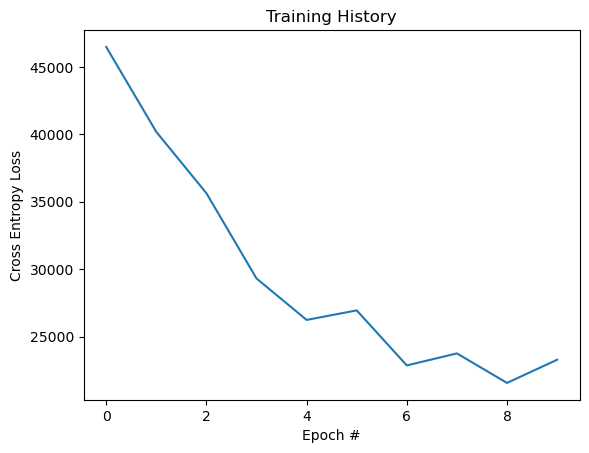

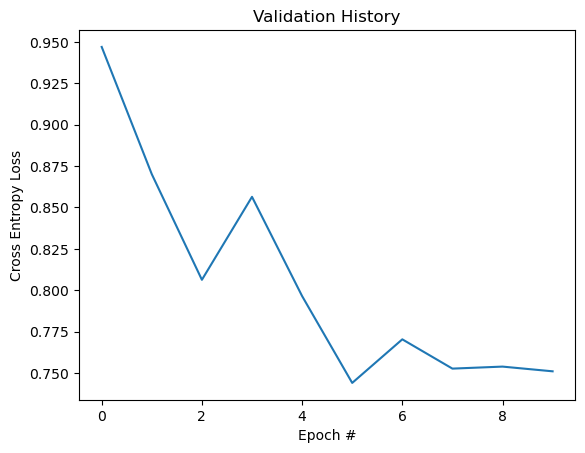

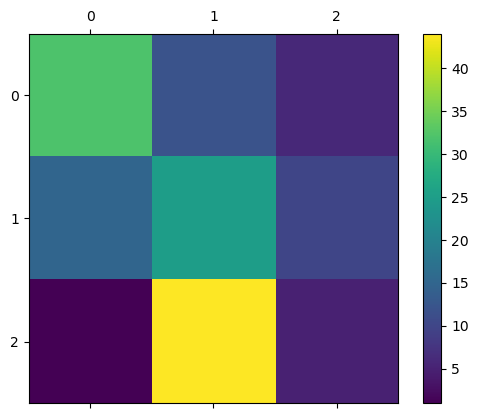

<Figure size 640x480 with 0 Axes>

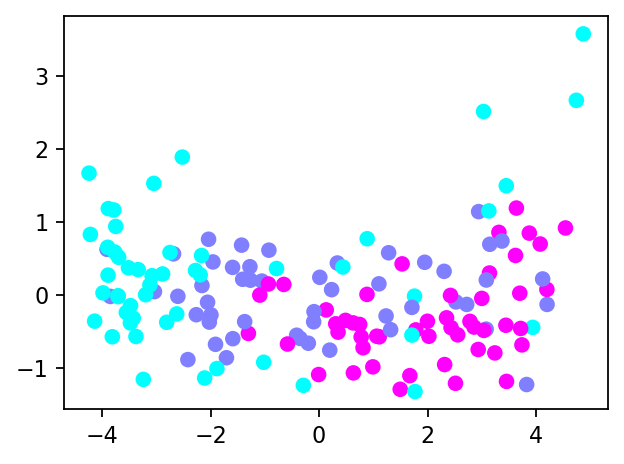

<Figure size 640x480 with 0 Axes>

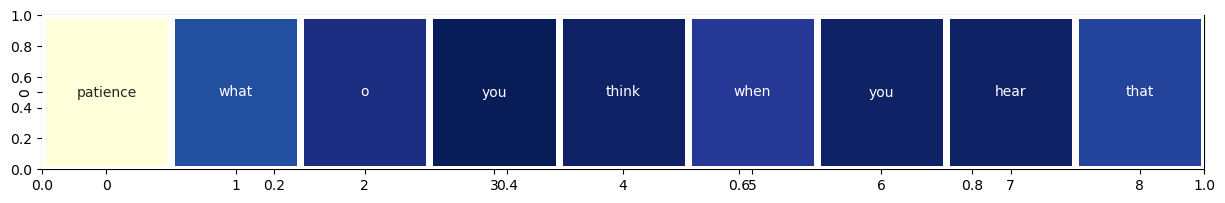

In [37]:
# 0, 0 = baseline
# 1, 0 = siamese contrastive
# 2, 0 = siamese triplet
# 1, 1 = siamese LSTM
import os
basedir = '/home/ubuntu/SiamAES/Experiments/m-triplet-contrastive.n-each=NEACH.n-augment=NAUGMENT.n-classes=NCLASSES'
n_each = 1
num_classes = 2
n_augment = 1
lr = 5e-4
num_epochs = 10
dirpath = basedir.replace("NEACH", str(n_each)).replace("NCLASSES", str(num_classes)).replace("NAUGMENT", str(n_augment))
if(os.path.isdir(dirpath)):
    shutil.rmtree(dirpath)
os.mkdir(dirpath)
run(num_classes, n_each, n_augment, dirpath, 2, 0, num_epochs, lr)

In [ ]:
with open('/content/summary.pickle', 'rb') as f:
    x = pickle.load(f)
print(x)